#@title Task 1 & 2 Summary – What This Notebook Does

Overview:
This notebook implements Task 1 and Task 2 of the Image Captioning Lab.

Task 1: Image Feature Extraction
- We use a pretrained CNN (ResNet50) to extract visual features from images.
- The image is resized and normalized to match the expected input format of the CNN.
- The CNN outputs a feature map representing the image’s content.
- These feature vectors are passed on to the caption model.

Task 2: Language (Caption) Model
- We define a caption decoder using an LSTM network.
- The model takes a sequence of word indices (representing a caption) and learns to generate the next word.
- This decoder will eventually work alongside the image features to generate meaningful captions.
- 
Task 3: Combining embeddings
- We decided to use concatenation to combine the embeddings
- The combined embeddings will be used during training
- 
Task 4: Training the network
- Network trained using regular gradient descent
- Hyper-params were tweaked manually untill an acceptable outcome was reached
- Early stoppage to speed up hyper param testing and save on resources

Task 5: Evaluation and testing
- We display training results and then test the model
- Model is tested by feeding in images and comparing the original caption to the model caption


Notebook Structure:
1. Install required libraries
2. Hyperparameters
3. Define the ImageEncoder class (ResNet50-based)
4. Define image transformation & loading functions
5. Preview original images from the dataset (grid of 10)
6. Show how the model sees images after transformation
7. Define the CaptionDecoder class (LSTM-based)
8. Test the decoder using dummy input to verify shape and functionality
9. Build vocabulary
10. 

In [29]:
#@title 1. Import Libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import nltk
from torch.nn.utils.rnn import pack_padded_sequence

nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\Deborah
[nltk_data]     Aittokallio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
#@title  Hyperparameters

batch_size        = 32      # images per batch
num_epochs        = 20      # upper-limit; early-stopping will usually halt sooner
embed_size        = 256     # word & image embedding size
hidden_size       = 512     # LSTM hidden units
num_layers        = 1       # LSTM layers
freq_threshold    = 5       # keep words that appear ≥5×
learning_rate     = 1e-3
step_lr_step      = 5       # lr scheduler: step every 5 epochs
step_lr_gamma     = 0.8
early_patience    = 3       # epochs of no val-loss improve before stop
max_caption_len   = 30      # generation cutoff
device = "cuda" if torch.cuda.is_available() else "cpu"


In [31]:
#@title 3. Define Image Encoder (CNN)

class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # remove last fc and avgpool
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        for param in self.resnet.parameters():  #  fixed typo here
            param.requires_grad = False  # freeze pretrained CNN

    def forward(self, images):
        features = self.resnet(images)             # (batch_size, 2048, H/32, W/32)
        features = self.adaptive_pool(features)    # (batch_size, 2048, 14, 14)
        features = features.permute(0, 2, 3, 1)     # (batch_size, 14, 14, 2048)
        return features


In [32]:
#@title 4. Image Preprocessing Function

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # (1, 3, 256, 256)
    return image

# Load and encode a sample image (r
try:
    image_tensor = load_image(r"Images/2186139563_e60c1d4b8b.jpg")
except:
    print("Failed to load image make sure the images are in a folder called Images in same directory as the file")
          
encoder = ImageEncoder()

with torch.no_grad():
    image_features = encoder(image_tensor)

print("Image feature shape:", image_features.shape)


Image feature shape: torch.Size([1, 14, 14, 2048])


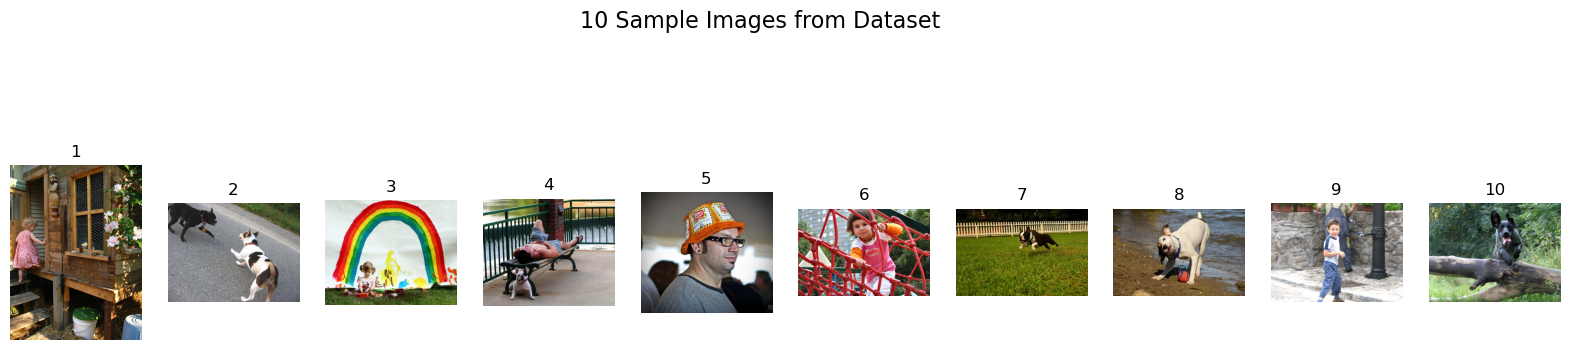

In [33]:
#@title 5. Show 10 Original Images (Preview as Grid)
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder where your dataset is stored
image_folder = r"Images"

# Get first 10 JPEG images in the folder
all_images = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
sample_images = all_images[:10]  # pick first 10

# Plot them in a horizontal row
plt.figure(figsize=(20, 5))

for i, image_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, image_name)
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{i+1}")

plt.suptitle("10 Sample Images from Dataset", fontsize=16)
plt.show()


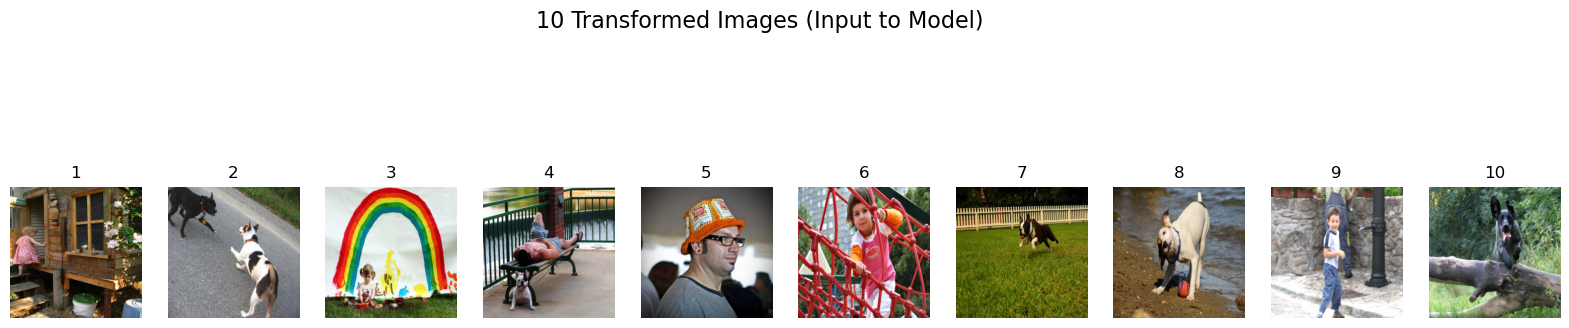

In [34]:
#@title 6. Show 10 Transformed Images (Post-Processing)

def show_transformed_images(image_folder, image_names, transform):
    plt.figure(figsize=(20, 5))

    for i, image_name in enumerate(image_names):
        img_path = os.path.join(image_folder, image_name)
        image = Image.open(img_path).convert('RGB')
        transformed = transform(image).unsqueeze(0)  # add batch dimension

        # Undo normalization for display
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        transformed = transformed.squeeze(0)  # remove batch dimension
        transformed = transformed * std[:, None, None] + mean[:, None, None]
        transformed = transformed.clamp(0, 1)

        np_image = transformed.permute(1, 2, 0).numpy()

        plt.subplot(1, 10, i + 1)
        plt.imshow(np_image)
        plt.axis('off')
        plt.title(f"{i+1}")

    plt.suptitle("10 Transformed Images (Input to Model)", fontsize=16)
    plt.show()

# Reuse the folder and image list from step 5
show_transformed_images(image_folder, sample_images, transform)


In [35]:
#@title 7. Define Caption Decoder (LSTM)

class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, captions, features, lengths):
        embeddings = self.embed(captions)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs


In [36]:
#@title 8. Test Decoder with Dummy Caption Input
# Decoder Test (Structure Only)

"""
We're only testing the decoder model here — not generating actual captions yet.

- Creates random word indices to simulate a caption (dummy input)
- Passes them through the decoder with image features
- Output is a `(10, 5000)` tensor of raw prediction scores (not human-readable words)
- Actual caption generation happens after training, during inference
"""

# Define dummy parameters
batch_size = 1
vocab_size = 5000       
embed_size = 256        
hidden_size = 512       
caption_length = 10    

# Create dummy caption tokens: shape = (batch_size, caption_length)
dummy_captions = torch.randint(0, vocab_size, (batch_size, caption_length))

# Simulate caption length list (used by pack_padded_sequence)
dummy_lengths = [caption_length]

# Initialize the decoder
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers)

# Forward pass through the decoder
outputs = decoder(dummy_captions, image_features, dummy_lengths)

# Output shape should be (total_words, vocab_size) = (10, 5000)
print("Decoder output shape:", outputs.shape)


Decoder output shape: torch.Size([10, 5000])


In [37]:
#----------------------------------------------------------------#

In [38]:
#@title 9. Build Vocabulary & Tokenize Captions

import os, re
from collections import Counter, defaultdict

# ---------- EDIT THESE PATHS ----------
img_dir  = r"Lab3\Images"
cap_file = r"Lab3\captions.txt"
# --------------------------------------

freq_threshold = 5   # min word freq to keep

# ---------- Vocabulary class ----------
class Vocabulary:
    def __init__(self, freq_th):
        self.freq_th = freq_th
        self.itos = {0:"<pad>", 1:"<start>", 2:"<end>", 3:"<unk>"}
        self.stoi = {v:k for k,v in self.itos.items()}
    def __len__(self):
        return len(self.itos)
    def _tok(self, txt):
        txt = re.sub(r"[^a-z0-9]+", " ", txt.lower())
        return txt.split()
    def build(self, sentences):
        freq, idx = Counter(), 4
        for s in sentences:
            for t in self._tok(s):
                freq[t] += 1
                if freq[t] == self.freq_th:
                    self.stoi[t] = idx
                    self.itos[idx] = t
                    idx += 1
    def nums(self, txt):
        return [ self.stoi.get(t, 3) for t in self._tok(txt) ]

    numericalize = nums        
    # ------------------------------------

# ---------- Parse captions file ----------
captions_raw = defaultdict(list)
bad_lines = 0

with open(cap_file, "r", encoding="utf8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        pos = line.lower().find(".jpg")
        if pos == -1:
            bad_lines += 1
            continue                      # skip lines w/o '.jpg'
        img_file = line[:pos+4]           # inclusive .jpg
        caption  = line[pos+4:]           # rest of the line
        caption  = caption.lstrip(" \t,#0123456789")  # strip separators
        captions_raw[img_file].append(caption)

print(f"Skipped {bad_lines} malformed lines")

# ---------- Build vocabulary ----------
all_caps = [c for caps in captions_raw.values() for c in caps]
vocab = Vocabulary(freq_threshold)
vocab.build(all_caps)

print("\n✔ Parsed images :", len(captions_raw))
print("✔ Captions count:", len(all_caps))
print("✔ Vocab size    :", len(vocab))

# Show a quick sample
sample_key = next(iter(captions_raw))
print("\nSample image key :", sample_key)
print("Sample captions  :", captions_raw[sample_key][:2])


FileNotFoundError: [Errno 2] No such file or directory: 'Lab3\\captions.txt'

In [ ]:
#@title 10. Dataset & DataLoaders (uses train/val/test splits)
import torch, os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from torch.nn.utils.rnn import pad_sequence

# ---------- transforms ----------
transform_train = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225))
])

# ---------- dataset ----------
class FlickrDataset(Dataset):
    def __init__(self, img_dir, captions_dict, key_list, vocab, transform):
        self.ids   = key_list
        self.caps  = captions_dict
        self.vocab = vocab
        self.tf    = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_name = self.ids[idx]
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img = self.tf(img)

        caption = self.caps[img_name][0]      # use first caption
        tokens  = [1] + self.vocab.numericalize(caption) + [2]  # <start>, …, <end>
        return img, torch.tensor(tokens, dtype=torch.long)

# ---------- collate fn ----------
def collate(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs)
    lengths = torch.tensor([len(c) for c in caps])
    caps = pad_sequence(caps, batch_first=True, padding_value=0)
    return imgs, caps, lengths

# ---------- build loaders ----------
batch_size = 32   # or any value you set earlier

train_loader = DataLoader(
    FlickrDataset(img_dir, captions_raw, train_keys, vocab, transform_train),
    batch_size=batch_size, shuffle=True,  collate_fn=collate)

val_loader = DataLoader(
    FlickrDataset(img_dir, captions_raw, val_keys, vocab, transform_train),
    batch_size=batch_size, shuffle=False, collate_fn=collate)

test_loader = DataLoader(
    FlickrDataset(img_dir, captions_raw, test_keys, vocab, transform_train),
    batch_size=batch_size, shuffle=False, collate_fn=collate)

print(f"Loaders ready  |  train: {len(train_loader)}  val: {len(val_loader)}  test: {len(test_loader)}")


Loaders ready  |  train: 177  val: 38  test: 38


In [ ]:
#@title 11. Fusion Model (Concatenation) 
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights="DEFAULT")
        modules = list(resnet.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, embed_size)
        for p in self.cnn.parameters(): p.requires_grad=False
    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x).squeeze()   # (B,2048)
        return self.fc(x)            # (B,embed)

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm  = nn.LSTM(embed_size*2, hidden_size, num_layers,
                             batch_first=True)
        self.fc    = nn.Linear(hidden_size, vocab_size)
    def forward(self, feats, caps, lengths):
        emb_caps = self.embed(caps)                    # (B,L,E)
        feats = feats.unsqueeze(1).repeat(1, emb_caps.size(1),1) # (B,L,E)
        inputs = torch.cat([feats, emb_caps], dim=2)   # concat fusion
        packed = nn.utils.rnn.pack_padded_sequence(
            inputs, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h,_ = self.lstm(packed)
        outputs = self.fc(h.data)
        return outputs

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(
    list(decoder.parameters())+list(encoder.fc.parameters()),
    lr=learning_rate
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/walle/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:07<00:00, 13.3MB/s]


NameError: name 'vocab' is not defined

In [ ]:
#@title 12. Train & Validate w/ Early Stopping

criterion   = nn.CrossEntropyLoss(ignore_index=0)   # pad ignored
optimizer   = torch.optim.Adam(
    list(decoder.parameters()) + list(encoder.fc.parameters()),
    lr=learning_rate)
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.8)

EARLY_PATIENCE = 3        # epochs w/o val loss improve
best_val_loss  = float("inf")
best_state     = None
epochs_no_imp  = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

def token_accuracy(pred_logits, target_ids):
    preds = pred_logits.argmax(1)
    mask  = target_ids != 0          # ignore <pad>
    correct = (preds == target_ids) & mask
    return correct.float().sum() / mask.float().sum()

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    encoder.train(); decoder.train()
    tr_loss = tr_acc = tr_tokens = 0

    for imgs, caps, lengths in train_loader:
        imgs, caps = imgs.to(device), caps.to(device)
        feats = encoder(imgs)

        optimizer.zero_grad()
        logits = decoder(feats, caps[:, :-1], lengths - 1)
        targets = nn.utils.rnn.pack_padded_sequence(
            caps[:, 1:], lengths - 1, batch_first=True,
            enforce_sorted=False).data

        loss = criterion(logits, targets)
        loss.backward(); optimizer.step()

        tr_loss   += loss.item() * targets.size(0)
        tr_acc    += token_accuracy(logits, targets) * targets.size(0)
        tr_tokens += targets.size(0)

    train_loss = tr_loss / tr_tokens
    train_acc  = tr_acc  / tr_tokens
    scheduler.step()

    # -------- VALIDATE --------
    encoder.eval(); decoder.eval()
    val_loss = val_acc = val_tokens = 0
    with torch.no_grad():
        for imgs, caps, lengths in val_loader:
            imgs, caps = imgs.to(device), caps.to(device)
            logits = decoder(encoder(imgs), caps[:, :-1], lengths - 1)
            targets = nn.utils.rnn.pack_padded_sequence(
                caps[:, 1:], lengths - 1, batch_first=True,
                enforce_sorted=False).data

            l = criterion(logits, targets)
            val_loss   += l.item() * targets.size(0)
            val_acc    += token_accuracy(logits, targets) * targets.size(0)
            val_tokens += targets.size(0)

    val_loss /= val_tokens
    val_acc  /= val_tokens

    # store curves
    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc.item()); val_accs.append(val_acc.item())

    # -------- print epoch summary --------
    print(f"Epoch {epoch:02d} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.2%} || "
          f"Val loss {val_loss:.4f}, acc {val_acc:.2%}", end='')

    # early-stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state    = {
            "enc": encoder.state_dict(),
            "dec": decoder.state_dict()}
        epochs_no_imp = 0
    else:
        epochs_no_imp += 1
        print(f"   ⚠ ({epochs_no_imp}/{EARLY_PATIENCE})")
        if epochs_no_imp >= EARLY_PATIENCE:
            print(f"Stopping early at epoch {epoch}")
            break

# restore best
encoder.load_state_dict(best_state["enc"])
decoder.load_state_dict(best_state["dec"])
print(f"\n Restored model with best val_loss {best_val_loss:.4f}")


Epoch 01 | Train loss 4.4439, acc 27.37% || Val loss 3.7764, acc 33.51%   ✅
Epoch 02 | Train loss 3.4699, acc 36.32% || Val loss 3.3963, acc 37.26%   ✅
Epoch 03 | Train loss 3.0637, acc 39.74% || Val loss 3.2159, acc 38.81%   ✅
Epoch 04 | Train loss 2.7710, acc 42.24% || Val loss 3.1247, acc 40.15%   ✅
Epoch 05 | Train loss 2.5238, acc 44.93% || Val loss 3.0907, acc 40.34%   ✅
Epoch 06 | Train loss 2.2680, acc 48.14% || Val loss 3.0713, acc 40.76%   ✅
Epoch 07 | Train loss 2.0815, acc 50.64% || Val loss 3.0658, acc 41.18%   ✅
Epoch 08 | Train loss 1.9038, acc 53.57% || Val loss 3.0821, acc 40.95%   ⚠ (1/3)
Epoch 09 | Train loss 1.7267, acc 57.23% || Val loss 3.1200, acc 40.45%   ⚠ (2/3)
Epoch 10 | Train loss 1.5600, acc 60.90% || Val loss 3.1437, acc 40.39%   ⚠ (3/3)
Stopping early at epoch 10

☑️  Restored model with best val_loss 3.0658


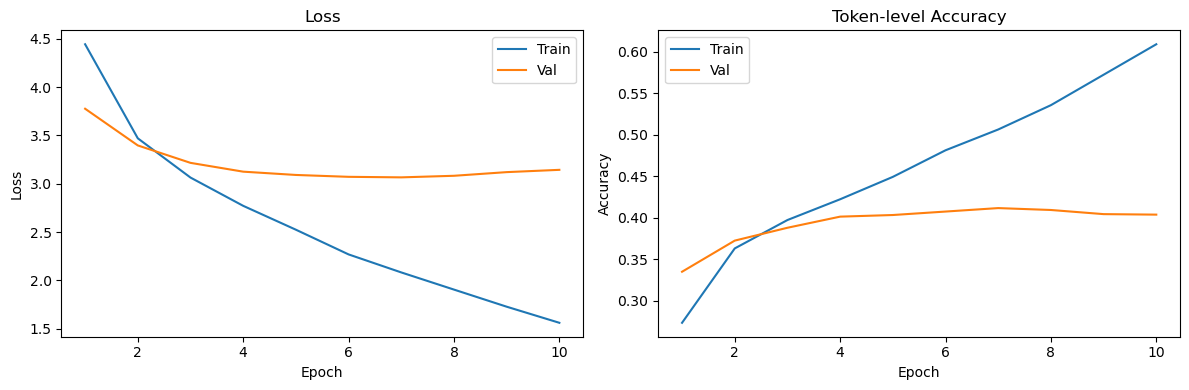

In [ ]:
#@title 13. Training vs. Validation plot
import matplotlib.pyplot as plt

epochs_ran = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12,4))

# ---- Loss curve ----
plt.subplot(1,2,1)
plt.plot(epochs_ran, train_losses, label="Train")
plt.plot(epochs_ran, val_losses,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss"); plt.legend()

# ---- Accuracy curve ----
plt.subplot(1,2,2)
plt.plot(epochs_ran, train_accs, label="Train")
plt.plot(epochs_ran, val_accs,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Token-level Accuracy"); plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#@title 14. caption generation
def generate_caption(image_path, max_len=max_caption_len):
    encoder.eval(); decoder.eval()

    img = transform_train(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = encoder(img)          # could be (E) or (1,E)
        if feat.dim() == 1:          # <-- ensure shape is (1,E)
            feat = feat.unsqueeze(0)

        word  = torch.tensor([vocab.stoi["<start>"]], device=device)
        hidden, cell = None, None
        caption_idx = []

        for _ in range(max_len):
            emb = decoder.embed(word).unsqueeze(1)      # (1,1,E)
            fused = torch.cat([feat.unsqueeze(1), emb], dim=2)  # (1,1,2E)

            output, (hidden, cell) = decoder.lstm(
                fused,
                (hidden, cell) if hidden is not None else None
            )
            preds = decoder.fc(output.squeeze(1))       # (1,V)
            word  = preds.argmax(1)
            if word.item() == vocab.stoi["<end>"]:
                break
            caption_idx.append(word.item())

        return " ".join(vocab.itos[i] for i in caption_idx) or "(empty caption)"


BLEU-1 0.543  BLEU-2 0.346  BLEU-3 0.175  BLEU-4 0.078


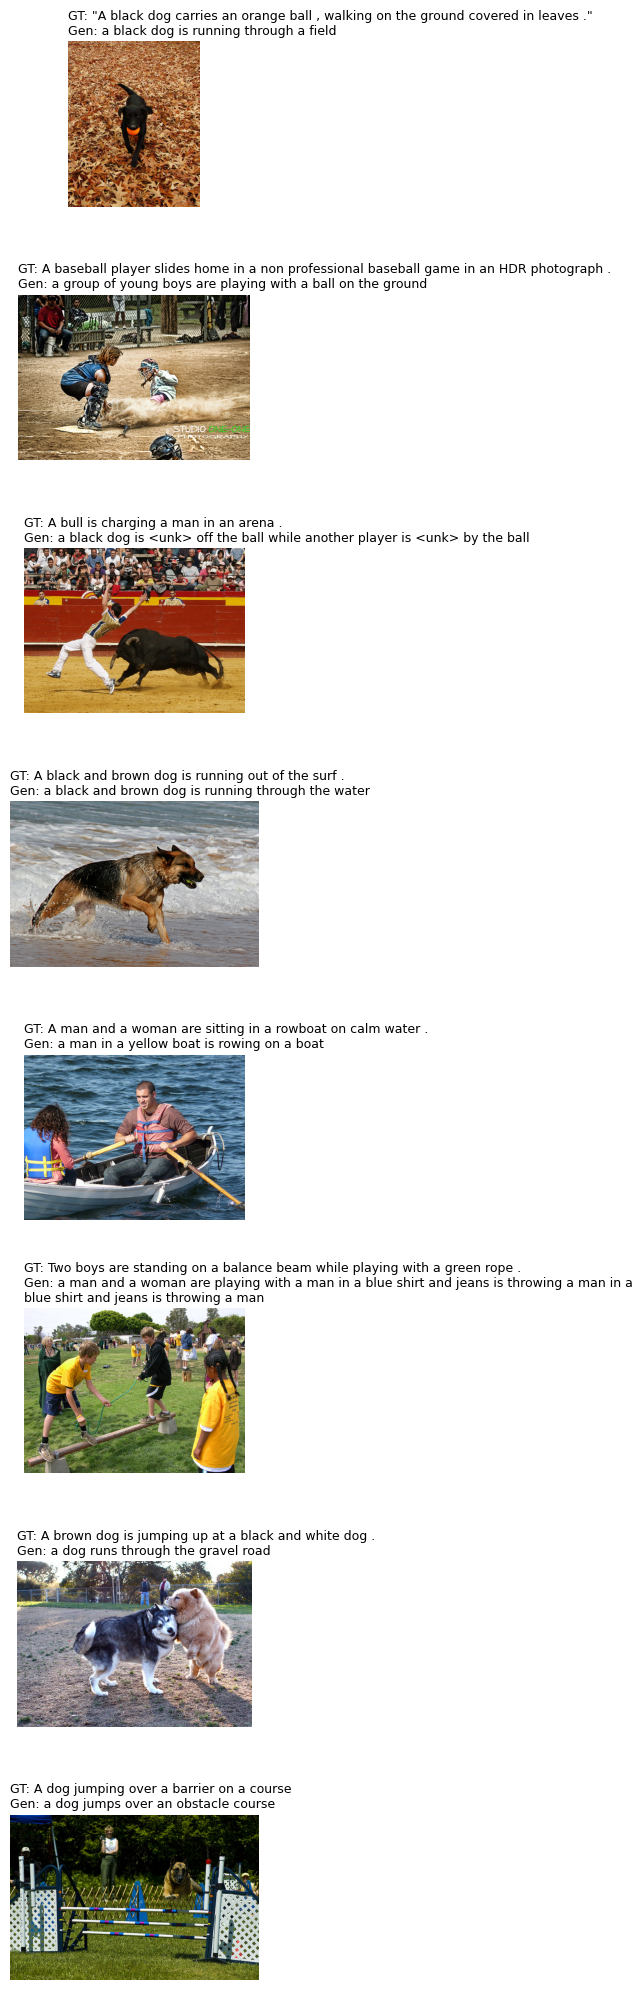

In [ ]:
#@title 15. Evaluation and visualisation of results (showing labeled captions and model captions)
import random, matplotlib.pyplot as plt, os
from nltk.translate.bleu_score import sentence_bleu

# ─── choose held-out keys (use test_keys from split) ───
vis_keys   = random.sample(test_keys, 8)     # show 8 images
bleu_keys  = test_keys                       # evaluate on all test

# ─── BLEU-1…4 on test set ───
def bleu_all(keys):
    tot = [0,0,0,0]
    for k in keys:
        ref  = [vocab._tok(c) for c in captions_raw[k]]   # 5 refs
        hyp  = generate_caption(os.path.join(img_dir,k)).split()
        tot  = [t + s for t,s in zip(tot, [
                sentence_bleu(ref,hyp,weights=(1,0,0,0)),
                sentence_bleu(ref,hyp,weights=(0.5,0.5,0,0)),
                sentence_bleu(ref,hyp,weights=(0.33,0.33,0.33,0)),
                sentence_bleu(ref,hyp,weights=(0.25,0.25,0.25,0.25))
        ])]
    N = len(keys)
    return [t/N for t in tot]

bleu_scores = bleu_all(bleu_keys)
print(f"BLEU-1 {bleu_scores[0]:.3f}  "
      f"BLEU-2 {bleu_scores[1]:.3f}  "
      f"BLEU-3 {bleu_scores[2]:.3f}  "
      f"BLEU-4 {bleu_scores[3]:.3f}")

# ─── nicer visual grid ───
n_show = len(vis_keys)
plt.figure(figsize=(10, n_show*2.5))

for i, key in enumerate(vis_keys):
    img_path = os.path.join(img_dir, key)
    img = Image.open(img_path).convert("RGB")
    gen = generate_caption(img_path)
    gt  = captions_raw[key][0]          # first GT caption

    # display image
    ax  = plt.subplot(n_show, 1, i+1)
    ax.imshow(img); ax.axis('off')

    # below image: ground truth (green) & generated (blue)
    ax.set_title(
        f"GT: {gt}\nGen: {gen}",
        loc="left",
        fontdict={"fontsize":9, "color":"black", "wrap":True}
    )
    ax.title.set_position([0.01, -0.15])    # move text below

plt.tight_layout(h_pad=3.0)
plt.show()
